### **Laboratorio 1**

### **Carga de Datos de Importacion Hidrocarburos**

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras


#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### **Datos de Importacion** 

In [109]:
df_import_2024 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx", skiprows=6)
df_import_2025 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx", skiprows=6)

print(df_import_2024.columns.tolist())

['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras', 'Combustible turbo jet', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior', 'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas', 'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano', 'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido', 'Total importación']


In [110]:

df_import_2024["Diesel"] = df_import_2024["Diesel alto azufre"] + df_import_2024["Diesel bajo azufre"]
df_import_2025["Diesel"] = df_import_2025["Diesel bajo azufre"]


In [111]:

columnas_deseadas = [
    "Fecha",
    "Gasolina Regular",
    "Gasolina Superior",
    "Diesel",
    "Gas Licuado De Petróleo"
]


df_import_2024.columns = df_import_2024.columns.str.strip().str.title()
df_import_2025.columns = df_import_2025.columns.str.strip().str.title()


df_2024_cols = df_import_2024[columnas_deseadas].copy()
df_2025_cols = df_import_2025[columnas_deseadas].copy()


df_total = pd.concat([df_2024_cols, df_2025_cols], ignore_index=True)


df_total["Fecha"] = pd.to_datetime(df_total["Fecha"], errors="coerce")


df_importacion_total = df_total.dropna()


df_importacion_total.set_index("Fecha", inplace=True)



In [112]:
df_importacion_total.to_csv("importacion_completa.csv", index=True)
# Cambiar nombre de columna
df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)

airPas = df_importacion_total["Gasolina regular"]


C:\Users\juans\AppData\Local\Temp\ipykernel_3152\1058275361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)


In [113]:
df_importacion_total.head()

,Gasolina regular,Gasolina Superior,Diesel,Gas Licuado De Petróleo
Fecha,,,,
2001-01-01,177776.50,373963.96,566101.99,194065.738095
2001-02-01,123115.99,243091.07,489525.80,170703.380952
2001-03-01,161726.42,312084.38,575559.68,161837.371429
2001-04-01,127338.74,285054.89,437745.42,163048.642857
2001-05-01,168730.19,300913.67,552609.13,171518.861905


In [114]:
df_importacion_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2001-01-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina Superior        293 non-null    float64
 2   Diesel                   293 non-null    float64
 3   Gas Licuado De Petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


## **Inciso 3**

### **Serie de Tiempo Gasolina Regular**

##### **Inicio, fin y frecuencia**

In [115]:
serie = df_importacion_total["Gasolina regular"]
inicio = serie.index.min()
fin = serie.index.max()
frecuencia = pd.infer_freq(serie.index)

print("Inicio:", inicio)
print("Fin:", fin)
print("Frecuencia:", frecuencia)


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


#### **Gráfico de la serie**

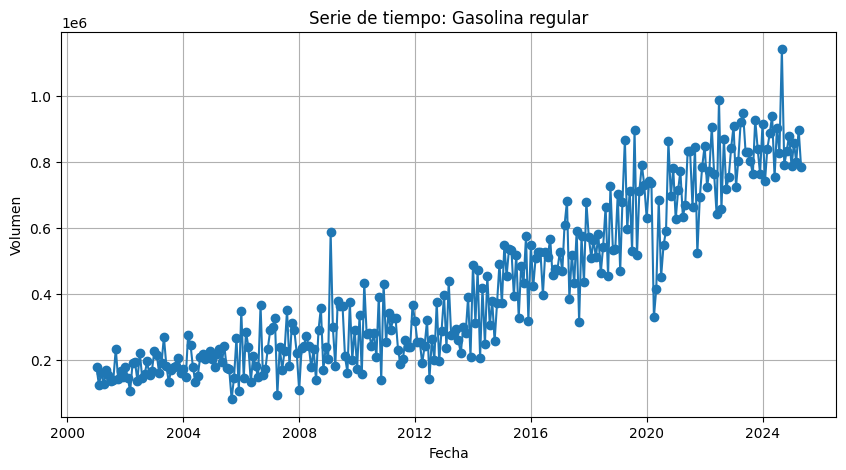

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(serie, marker='o', linestyle='-')
plt.title("Serie de tiempo: Gasolina regular")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


#### **Descomposición de la serie**

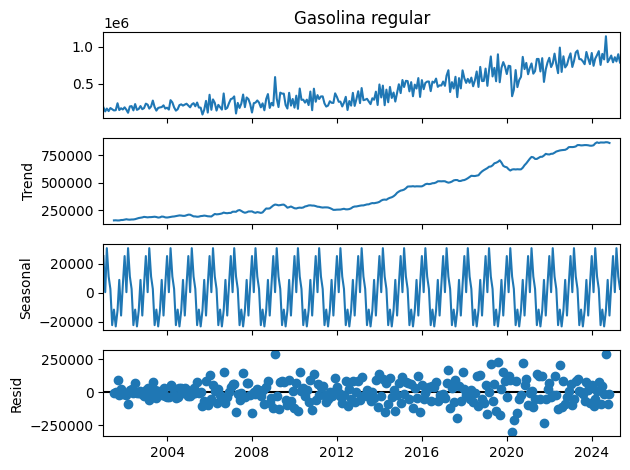

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie, model="additive", period=12)
descomposicion.plot()
plt.tight_layout()
plt.show()


Al descomponer la serie de tiempo de gasolina regular en sus componentes —tendencia, estacionalidad y residuo— se pueden observar varios comportamientos importantes. La tendencia muestra un crecimiento sostenido a lo largo del tiempo, particularmente acelerado a partir del año 2015, lo que indica que el volumen importado ha aumentado de forma constante en los últimos años. En cuanto al componente estacional, se identifica un patrón regular y repetitivo a lo largo de cada año. Este comportamiento estacional sugiere que existen ciertos meses en los que el consumo o la importación de gasolina regular tiende a aumentar o disminuir de manera sistemática, lo cual podría estar vinculado a factores climáticos, económicos o sociales.l componente de residuo no presenta una estructura clara, pero se observa que su variabilidad parece incrementarse en los años más recientes. Esto sugiere un posible aumento en la varianza, lo que es importante al analizar la estacionariedad.

Con base en estos componentes, se puede concluir que la serie no es estacionaria en media, debido a la presencia de una tendencia creciente. Asimismo, la estacionariedad en varianza también es cuestionable, ya que la amplitud de las fluctuaciones residuales tiende a crecer con el tiempo. Por lo tanto, antes de aplicar modelos de pronóstico, sería recomendable transformar la serie para lograr condiciones más cercanas a la estacionariedad.

#### **Transformar la serie**

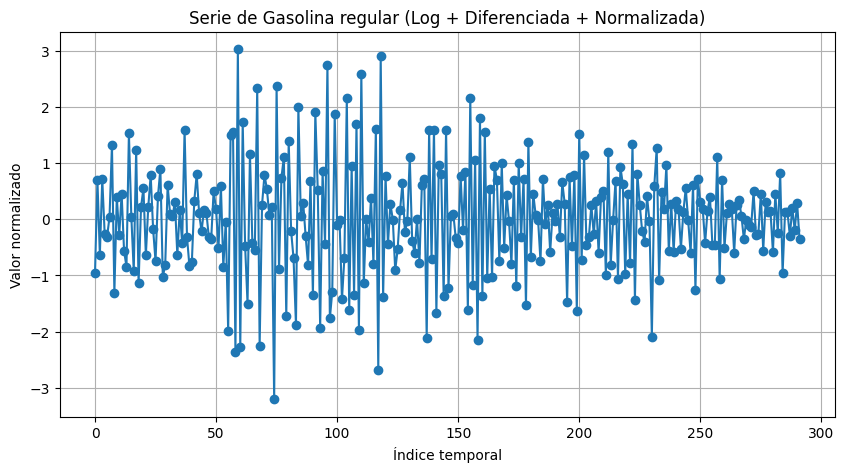

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


serie_log = np.log(df_importacion_total["Gasolina regular"])


serie_estacionaria = serie_log.diff().dropna()


scaler = StandardScaler()
serie_normalizada = scaler.fit_transform(serie_estacionaria.values.reshape(-1, 1))


plt.figure(figsize=(10, 5))
plt.plot(serie_normalizada, linestyle='-', marker='o')
plt.title("Serie de Gasolina regular (Log + Diferenciada + Normalizada)")
plt.xlabel("Índice temporal")
plt.ylabel("Valor normalizado")
plt.grid(True)
plt.show()


### **Division de Prueba y entrenamiento**

In [119]:

serie = serie_normalizada  


entrenamiento = round(0.6 * len(serie))
val_prueba = round(0.2 * len(serie))


test = serie[(entrenamiento + val_prueba):]
validation = serie[entrenamiento:entrenamiento + val_prueba]
train = serie[:entrenamiento]


train = np.reshape(train, (train.shape[0], 1))


print("Entrenamiento:", len(train))
print("Validación:", len(validation))
print("Prueba:", len(test))


Entrenamiento: 175
Validación: 58
Prueba: 59


In [120]:
from operator import concat


def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:i + retrasos, 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)


x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)


print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


[[-0.96092422]
 [ 0.69056993]
 [-0.62982832]
 [ 0.71293864]
 [-0.26729129]
 [-0.30960783]]
[[-0.96092422]
 [ 0.69056993]
 [-0.62982832]
 [ 0.71293864]
 [-0.26729129]
 [-0.30960783]]
[ 0.69056993 -0.62982832  0.71293864 -0.26729129 -0.30960783  0.04425754]


#### **Creacion de modelo TensorFlor**

In [121]:

x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
x_val = np.reshape(x_val, (x_val.shape[0], 1, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))


print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)


x_train shape: (174, 1, 1)
x_val shape: (57, 1, 1)
x_test shape: (58, 1, 1)


In [122]:
import tensorflow as tf
from tensorflow import keras


lote = 1           
unidades = 1       
paso = 1           
caracteristicas = 1  


inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [123]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Compilar el modelo
modelo1.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.1),
    metrics=[RootMeanSquaredError()]
)


In [124]:
epocas = 150  

history = modelo1.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    
    verbose=1
)


Epoch 1/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9058 - root_mean_squared_error: 0.9375 - val_loss: 0.4420 - val_root_mean_squared_error: 0.6649
Epoch 2/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8264 - root_mean_squared_error: 0.8887 - val_loss: 0.4498 - val_root_mean_squared_error: 0.6707
Epoch 3/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8254 - root_mean_squared_error: 0.8906 - val_loss: 0.4388 - val_root_mean_squared_error: 0.6624
Epoch 4/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8213 - root_mean_squared_error: 0.8863 - val_loss: 0.4539 - val_root_mean_squared_error: 0.6737
Epoch 5/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8329 - root_mean_squared_error: 0.8954 - val_loss: 0.4326 - val_root_mean_squared_error: 0.6577
Epoch 6/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8216 - root_mean_squared_error: 0.8865 - val_loss: 0.4541 - val_root_mean_squared_error: 0.6738
Epoch 7/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

In [ ]:
import numpy as np
from pandas import Series

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    i = 0
    for X in data:
        
        X = np.reshape(X, (1, 1, 1))

        
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)

        
        yhat = scaler.inverse_transform(yhat)

        
        if dif:
            yhat = yhat + Series[n + dif_cant * i]

        
        yhat = np.exp(yhat)

        
        prediccion[i] = yhat[0][0]
        i += 1

    return prediccion


In [126]:

serie_log_original = np.log(df_importacion_total["Gasolina regular"])


prediccion_val = prediccion_fun(
    x_val, modelo1, 1, scaler,
    dif=True, dif_cant=1,
    Series=serie_log_original.values, n=entrenamiento
)

prediccion_test = prediccion_fun(
    x_test, modelo1, 1, scaler,
    dif=True, dif_cant=1,
    Series=serie_log_original.values, n=entrenamiento + val_prueba
)


In [127]:
len(prediccion_val), len(prediccion_test)

idx_val = airPas.index[entrenamiento : entrenamiento + len(prediccion_val)]
idx_test = airPas.index[entrenamiento + val_prueba : entrenamiento + val_prueba + len(prediccion_test)]


df_val = pd.DataFrame(prediccion_val, index=idx_val)
df_test = pd.DataFrame(prediccion_test, index=idx_test)


In [128]:

serie_log = np.log(df_importacion_total["Gasolina regular"]).values


start = entrenamiento + val_prueba
difs = y_test.flatten()
log_prev = serie_log[start : start + len(difs)]  


valores_reales = np.exp(log_prev + difs)


In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(valores_reales, prediccion_test)
rmse = np.sqrt(mean_squared_error(valores_reales, prediccion_test))
r2 = r2_score(valores_reales, prediccion_test)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 267662.96
RMSE: 366701.74
R² Score: 0.3257


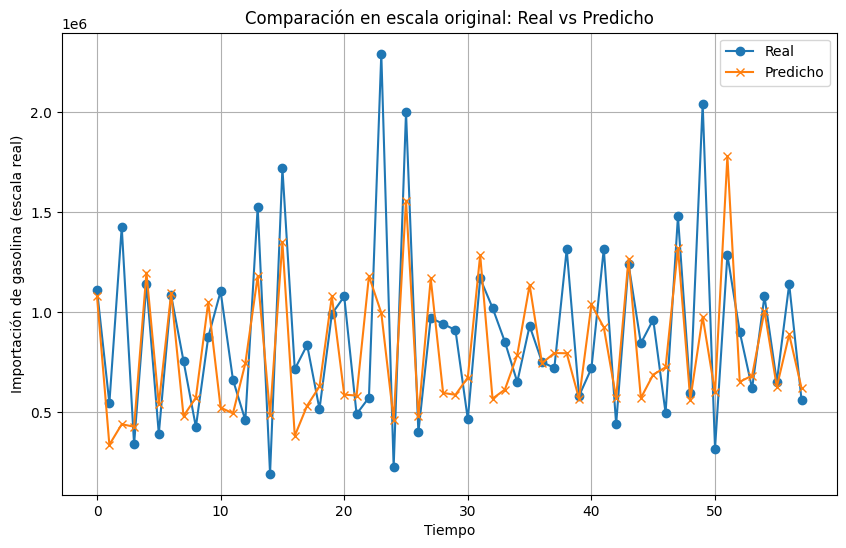

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(valores_reales, label="Real", marker='o')
plt.plot(prediccion_test, label="Predicho", marker='x')
plt.title("Comparación en escala original: Real vs Predicho")
plt.xlabel("Tiempo")
plt.ylabel("Importación de gasolina (escala real)")
plt.legend()
plt.grid(True)
plt.show()


In [131]:
from tensorflow.keras.models import save_model, load_model
import os
os.makedirs("Modelos", exist_ok=True)
save_model(modelo1, "Modelos/lstm1_serie_tiempo.keras")


### **modelo con Pytorch**

In [173]:
class LSTMMiModelo(nn.Module):
    def __init__(self,input_size=1,hidden_size=64, num_layers = 1,output_size = 1 ):
        super().__init__()
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  
        self.hidden_size = hidden_size

    def forward(self,x):
        # x shape: (batch, seq_len, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        

In [174]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 24 #Por el ciclo estacional, una ventana de un año

# Después, rehace tus ventanas:
x_train, y_train = create_sequences(train, SEQ_LENGTH)
x_val, y_val     = create_sequences(validation, SEQ_LENGTH)
x_test, y_test   = create_sequences(test, SEQ_LENGTH)


In [176]:
model = LSTMMiModelo()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Preparación de los datos
x_train_tensor = torch.from_numpy(x_train).float()        
y_train_tensor = torch.from_numpy(y_train).float()
x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:

train_losses = []
val_losses = []
model.train()
running_train_loss = 0.0
for epoch in range(epocas):
    running_train_loss = 0.0  
    for xb, yb in train_loader:  
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)
    
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) 

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = loss_fn(outputs, yb)
            running_val_loss += loss.item() * xb.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Loss promedio: {epoch_train_loss:.5f}")

Epoch 1, Loss promedio: 1.45157
Epoch 10, Loss promedio: 0.76983
Epoch 20, Loss promedio: 0.62607
Epoch 30, Loss promedio: 0.53995
Epoch 40, Loss promedio: 0.40010
Epoch 50, Loss promedio: 0.34824
Epoch 60, Loss promedio: 0.16598
Epoch 70, Loss promedio: 0.04681
Epoch 80, Loss promedio: 0.03155
Epoch 90, Loss promedio: 0.00233
Epoch 100, Loss promedio: 0.00019
Epoch 110, Loss promedio: 0.00006
Epoch 120, Loss promedio: 0.00001
Epoch 130, Loss promedio: 0.00000
Epoch 140, Loss promedio: 0.00000
Epoch 150, Loss promedio: 0.00000


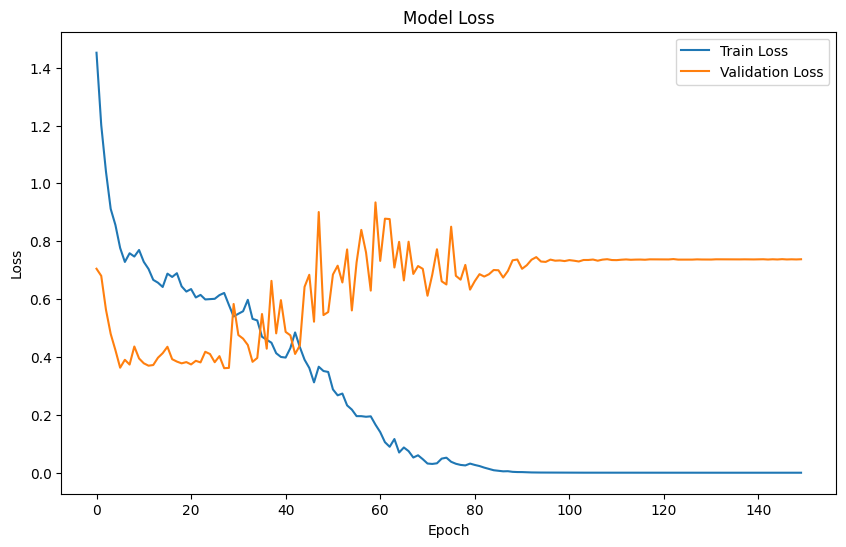

In [178]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
model.eval()
with torch.no_grad():
    
    y_pred_test = model(x_test_tensor)
    y_pred_test = y_pred_test.numpy()  

In [181]:
print(y_pred_test.shape)


(35, 1)


In [182]:
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
serie_log = np.log(df_importacion_total["Gasolina regular"]).values


start = entrenamiento + val_prueba + SEQ_LENGTH
log_prev = serie_log[-len(y_test_inv):]


valores_reales = np.exp(log_prev + y_test_inv.flatten())
valores_predichos = np.exp(log_prev + y_pred_test_inv.flatten())


mae = mean_absolute_error(valores_reales, valores_predichos)
rmse = np.sqrt(mean_squared_error(valores_reales, valores_predichos))
r2 = r2_score(valores_reales, valores_predichos)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 151406.54
RMSE: 192674.65
R² Score: 0.3704


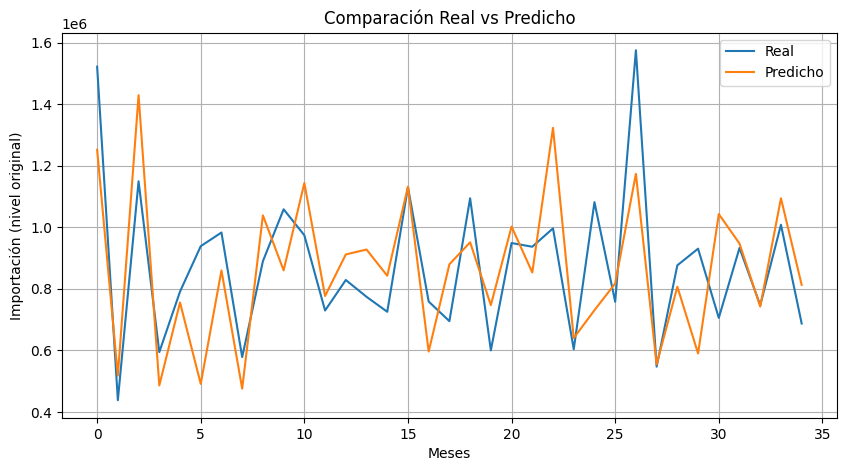

In [183]:
plt.figure(figsize=(10,5))
plt.plot(valores_reales, label="Real")
plt.plot(valores_predichos, label="Predicho")
plt.title("Comparación Real vs Predicho")
plt.xlabel("Meses")
plt.ylabel("Importación (nivel original)")
plt.legend()
plt.grid(True)
plt.show()


### **¿Cual fue el mejor modelo? ¿Fueron mejores a los modelos creados anteriormente?**

Basándose en los resultados obtenidos, el modelo con PyTorch obtuvo un mejor rendimiento teniendo un R² de 0.37, mejorando el 0.33 del modelo con TensorFlow. De igual manera, mostró una mayor estabilidad durante el entrenamiento, con pérdidas de validación más consistentes y menor sobreajuste.La razon de esto se puede deber a la flexibilidad de PyTorch permitió un mejor control sobre la arquitectura del modelo y el manejo de secuencias, lo cual fue clave al trabajar con datos temporales con fuerte estacionalidad. Esta ventaja se reflejó en una mejor capacidad del modelo para capturar patrones a largo plazo. En general son peroes que los modelos creados en el laboratorio pasado, debido a que los anteriores obtenian un R^2 de 0.8 a 0.9, un valor bastante alto. Una de las razones por las que pudo haber sido esto es al momento de la normalizacion de los datos y que al momento de regresarlos exista un desfase.